# Store sales prediction

For the hypothetical scenario of this notebook I will be using this dataset to predict the USD sales of a store based upon its square footage, average customers and number of items for sale. There are many real world uses for this sort of prediction from finanical planning to staff numbers for rotas.

This is a very simple task and I will be implimenting as Random Forest Regressor using sklearn to so this.

Data link: https://www.kaggle.com/datasets/surajjha101/stores-area-and-sales-data

### Imports

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error


### Load the data

In [2]:
file = "Stores.csv"
df = pd.read_csv(file, index_col=0)
df.head()

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
Store ID,,,,
1,1659,1961,530,66490
2,1461,1752,210,39820
3,1340,1609,720,54010
4,1451,1748,620,53730
5,1770,2111,450,46620


In [3]:
df.shape

(896, 4)

In [4]:
df.isnull().sum()

Store_Area              0
Items_Available         0
Daily_Customer_Count    0
Store_Sales             0
dtype: int64

Here we can see that there are no missing values in the data.

Next I will plot some joint plot graphs using seaborn to visulize the distrubitions of the variables and correlation in realtion to the store sales.

note: Unfortunately sns.jointplots aren't supported with subplots so these are plotted as seperate figures.

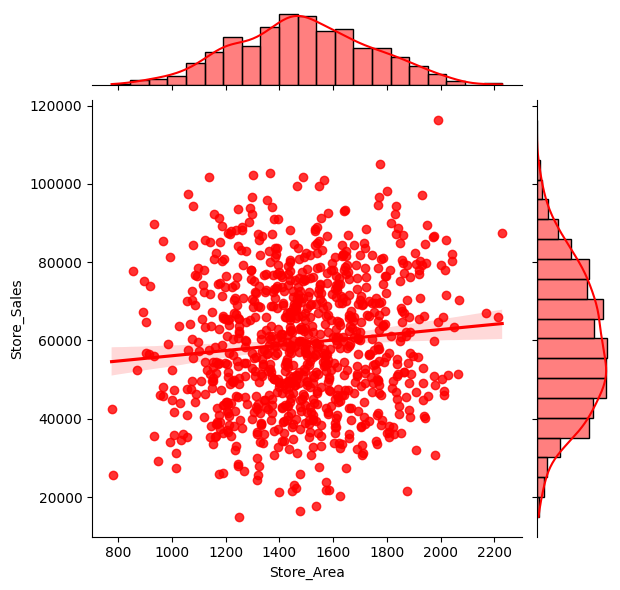

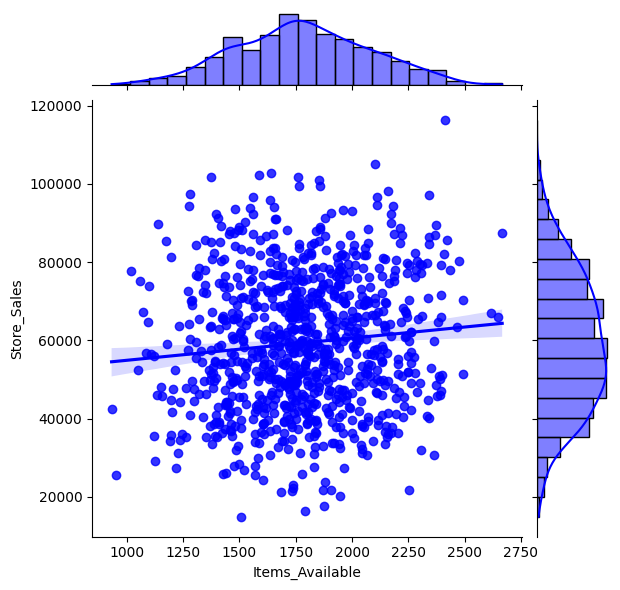

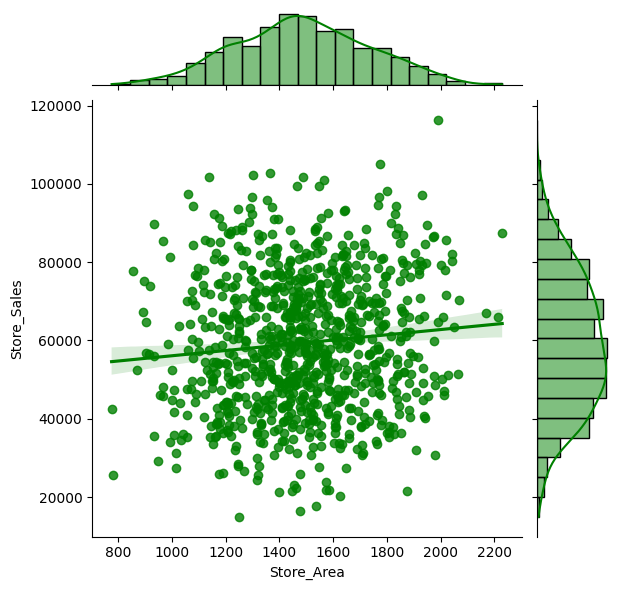

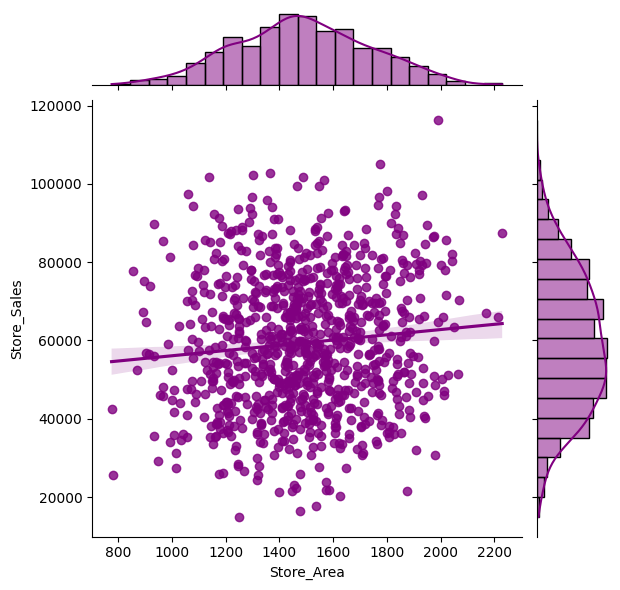

In [5]:
sns.jointplot(data=df, x="Store_Area", y="Store_Sales",kind="reg", color="red")
sns.jointplot(data=df, x="Items_Available", y="Store_Sales",kind="reg", color="blue")
sns.jointplot(data=df, x="Store_Area", y="Store_Sales",kind="reg",  color="green")
sns.jointplot(data=df, x="Store_Area", y="Store_Sales",kind="reg",  color="purple")


These plots show there is a correlation between the features and the target but also shows a lot of noise. This will make predictions less accurate.

### Feature Engineering

In order to make a prediction for the days sales before the day has happened we won't be able to use the "Daily_Customer_Count" as a feature of the model as the day hasnt happened which also means we won't know how many customers there will be. To solve this issue I'm going to make a new column that contains the average customers for the week prior to the day as a feauture.

In [6]:
df["7_day_avg"] = df["Daily_Customer_Count"].rolling(7).mean()
df.head()

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,7_day_avg
Store ID,,,,,
1,1659,1961,530,66490,NaN
2,1461,1752,210,39820,NaN
3,1340,1609,720,54010,NaN
4,1451,1748,620,53730,NaN
5,1770,2111,450,46620,NaN


In [7]:
df.dropna(inplace=True) #Drop the nan values the rolling average creates

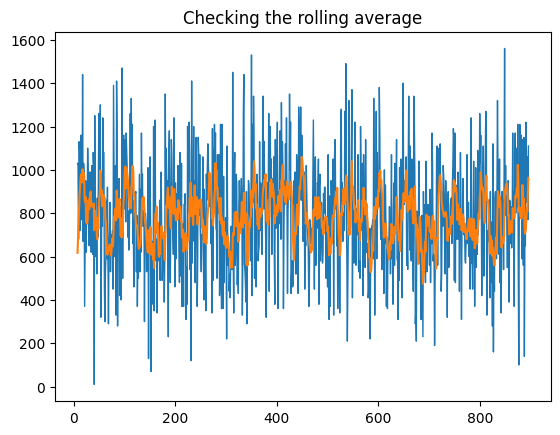

In [8]:
plt.title("Checking the rolling average")
plt.plot(df["Daily_Customer_Count"], linewidth=1)
plt.plot(df["7_day_avg"])

This plot is just to quickly and visually check the new "7_day_avg" series against the "Daily_Customer_Count" series incase there was any issues. Before I move on to splitting the data I will create a correlation matrix to see the affect each column has on the target variable.

In [9]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,7_day_avg
Store_Area,1.000000,0.998895,-0.039794,0.097838,0.013389
Items_Available,0.998895,1.000000,-0.039492,0.099233,0.014733
Daily_Customer_Count,-0.039794,-0.039492,1.000000,0.004874,0.388512
Store_Sales,0.097838,0.099233,0.004874,1.000000,0.028256
7_day_avg,0.013389,0.014733,0.388512,0.028256,1.000000


### Splitting the data

In [10]:
X = df[["Store_Area", "Items_Available", "7_day_avg"]].values #feautures
y = df["Store_Sales"].values #Target
X_train, X, y_train, y = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X, y, test_size=0.5, random_state=42)

Here I have made train, val, test split so I can keep the test set back to only be used after I have trained multiple models. This prevents it from inadvertantly becoming part of the training set.

### Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_val)
lr_mape = mean_absolute_percentage_error(y_val,lr_pred)
lr_mae = mean_absolute_error(y_val,lr_pred)
lr_mse = mean_squared_error(y_val,lr_pred)
print("Metrics")
print(f"MAPE: {round(lr_mape,2)}")
print(f"MAE:  {round(lr_mae,2)}")
print(f"MSE:  {round(lr_mse,2)}")

Metrics
MAPE: 0.32
MAE:  15356.34
MSE:  341727907.79


These metrics are not that good and I'm going to try another model type to see if there are any improvments.

### Random Forest Regression Model

In [13]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [14]:
rfr_pred = rfr.predict(X_val)
rfr_mape = mean_absolute_percentage_error(y_val,rfr_pred)
rfr_mae = mean_absolute_error(y_val,rfr_pred)
rfr_mse = mean_squared_error(y_val,rfr_pred)
print("Metrics")
print(f"MAPE: {round(rfr_mape,2)}")
print(f"MAE:  {round(rfr_mae,2)}")
print(f"MSE:  {round(rfr_mse,2)}")

Metrics
MAPE: 0.32
MAE:  15992.12
MSE:  380260414.47


The metrics for this model are less than ideal with the average prediction being 32% off from the actual value and performing worse than the Linear regression model.

### Optimization time

In [15]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [16]:
rf = RandomForestRegressor()
grid_search = GridSearchCV(rf, param_grid, cv=5,scoring="neg_mean_squared_error",verbose=2,n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=2)

In [17]:
best_params = grid_search.best_params_
optim_rfr = grid_search.best_estimator_
print("Best Parameters:", best_params)

Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [18]:
optim_rfr_pred = optim_rfr.predict(X_val)
optim_rfr_mape = mean_absolute_percentage_error(y_val,optim_rfr_pred)
optim_rfr_mae = mean_absolute_error(y_val,optim_rfr_pred)
optim_rfr_mse = mean_squared_error(y_val,optim_rfr_pred)
print("Metrics")
print(f"MAPE: {round(optim_rfr_mape,2)}")
print(f"MAE:  {round(optim_rfr_mae,2)}")
print(f"MSE:  {round(optim_rfr_mse,2)}")

Metrics
MAPE: 0.31
MAE:  15253.97
MSE:  349372430.38


The optimization only resulted in a small improvement in the MAE and MSE scores. These scores from both linear and non-linear models even after optimization make me believe that this is the best accuracy I will achieve on this small data set.

### Compare all of the models scores on the test set that was kept back

In [21]:
models = [lr, rfr, optim_rfr]
for model in models:
    pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test,pred)
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    print("========================")
    print(f"Metrics for {model}:")
    print(f"MAPE: {round(mape,2)}")
    print(f"MAE:  {round(mae,2)}")
    print(f"MSE:  {round(mse,2)}")

Metrics for LinearRegression():
MAPE: 0.31
MAE:  14993.24
MSE:  310037655.45
Metrics for RandomForestRegressor():
MAPE: 0.33
MAE:  16123.4
MSE:  379987031.45
Metrics for RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=10):
MAPE: 0.32
MAE:  15707.7
MSE:  351650923.56


Here we can see the Linear Regression model is the "best" performer.

### Prediction function

In [22]:
def predict(model, store_area, items_available, seven_day_avg):
    input = [[float(store_area), items_available, float(seven_day_avg)]]
    
    return int(model.predict(input))
    

# Change these to get a new prediction
store_area = 1800
items = 1752
seven_day_avg = 780
    
print(f"The store is predicted to make ${predict(lr, store_area, items, seven_day_avg)} today.") 

The store is predicted to make $57076 today.


C:\Users\Max\AppData\Local\Temp\ipykernel_1328\2632822153.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(model.predict(input))


# Conclusion

In this notebook, I built a model to predict store sales using features like store area, average customers over a week, and number of items for sale. I used both a Linear Regression model and a Random Forest Regressor and visualized data correlations, though there was alot of noise in some feautres affecting accuracy. After tuning the model with GridSearchCV, I evaluated its performance using MAPE, MAE, and MSE. The model captures general trends but could be improved for better accuracy. Overall, this project illustrates the process of building and fine-tuning a sales prediction model.